# Importing Libraries and getting the data

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('bright')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold   
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

In [0]:
df_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/interest rate/test_fjtUOL8.csv")
df_train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/interest rate/train_fNxu4vz.csv")

In [76]:
df_train.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1


# EDA

In [77]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164309 entries, 0 to 164308
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Loan_ID                  164309 non-null  int64  
 1   Loan_Amount_Requested    164309 non-null  object 
 2   Length_Employed          156938 non-null  object 
 3   Home_Owner               138960 non-null  object 
 4   Annual_Income            139207 non-null  float64
 5   Income_Verified          164309 non-null  object 
 6   Purpose_Of_Loan          164309 non-null  object 
 7   Debt_To_Income           164309 non-null  float64
 8   Inquiries_Last_6Mo       164309 non-null  int64  
 9   Months_Since_Deliquency  75930 non-null   float64
 10  Number_Open_Accounts     164309 non-null  int64  
 11  Total_Accounts           164309 non-null  int64  
 12  Gender                   164309 non-null  object 
 13  Interest_Rate            164309 non-null  int64  
dtypes: f



*   Amount requested to be converted into int
*   home_owner has 4 main categories
*   income_verified 3 categories
*   Need to check categories under purpose_of loan
*   Months_Since_Deliquency seems to have many null values
*   NO interest rate missing in train data





In [78]:
df_train.groupby('Purpose_Of_Loan')['Loan_ID'].nunique()

Purpose_Of_Loan
car                    1885
credit_card           36684
debt_consolidation    97101
educational             121
home_improvement       9269
house                   773
major_purchase         3435
medical                1541
moving                  974
other                  8346
renewable_energy        123
small_business         2392
vacation                837
wedding                 828
Name: Loan_ID, dtype: int64

In [0]:
#y_train = df_train['Interest_Rate']

combining train and test data


In [80]:
frames = [df_train,df_test]
df = pd.concat(frames, keys=['x', 'y'])

df

Loan_ID Loan_Amount_Requested  ...  Gender Interest_Rate
x 0       10000001                 7,000  ...  Female           1.0
  1       10000002                30,000  ...  Female           3.0
  2       10000003                24,725  ...    Male           3.0
  3       10000004                16,000  ...    Male           3.0
  4       10000005                17,000  ...  Female           1.0
...            ...                   ...  ...     ...           ...
y 109536  10273846                15,000  ...    Male           NaN
  109537  10273847                 9,600  ...    Male           NaN
  109538  10273848                 2,000  ...    Male           NaN
  109539  10273849                 2,125  ...    Male           NaN
  109540  10273850                15,000  ...    Male           NaN

[273850 rows x 14 columns]

**MISSING VALUES**

In [81]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
Months_Since_Deliquency,147238,0.537659
Interest_Rate,109541,0.400004
Home_Owner,42060,0.153588
Annual_Income,42000,0.153369
Length_Employed,12307,0.044941


In [0]:
df.drop('Months_Since_Deliquency', axis = 1, inplace = True)

In [0]:
df['Annual_Income'].fillna(df['Annual_Income'].mean(), inplace = True)
df['Home_Owner'].fillna(method='ffill',inplace=True)
df['Length_Employed'].fillna(method='ffill',inplace=True)

In [0]:
df['Loan_Amount_Requested'] = df['Loan_Amount_Requested'].str.replace(",","").astype(float)

In [0]:
df_train = df.xs('x')
df_test = df.xs('y')

# DATA VISUALIZATION

In [86]:
df_train.describe()

,Loan_ID,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Interest_Rate
count,1.643090e+05,164309.00000,1.643090e+05,164309.000000,164309.000000,164309.000000,164309.000000,164309.000000
mean,1.008216e+07,14349.33692,7.334058e+04,17.207189,0.781698,11.193818,25.067665,2.158951
std,4.743207e+04,8281.86870,5.557440e+04,7.845083,1.034747,4.991813,11.583067,0.738364
min,1.000000e+07,500.00000,4.000000e+03,0.000000,0.000000,0.000000,2.000000,1.000000
25%,1.004108e+07,8000.00000,4.860000e+04,11.370000,0.000000,8.000000,17.000000,2.000000
50%,1.008216e+07,12075.00000,7.000000e+04,16.840000,0.000000,10.000000,23.000000,2.000000
75%,1.012323e+07,20000.00000,8.200000e+04,22.780000,1.000000,14.000000,32.000000,3.000000
max,1.016431e+07,35000.00000,7.500000e+06,39.990000,8.000000,76.000000,156.000000,3.000000


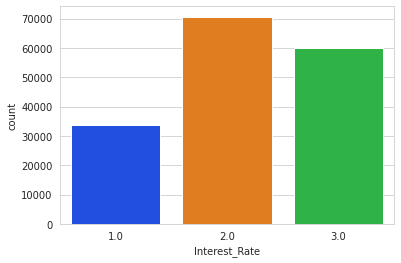

In [87]:
sns.countplot(x = 'Interest_Rate', data = df_train)

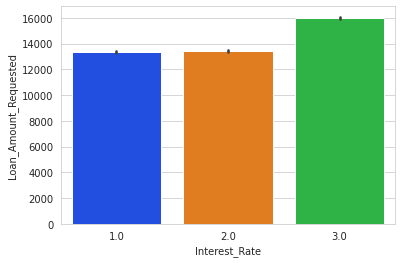

In [88]:
sns.barplot(x = 'Interest_Rate', y = 'Loan_Amount_Requested', data = df_train)

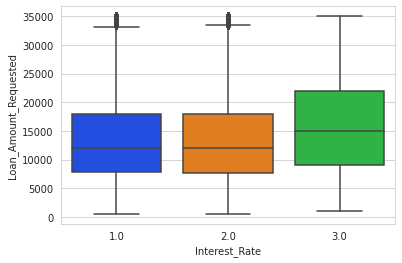

In [89]:
sns.boxplot('Interest_Rate','Loan_Amount_Requested', data = df_train)

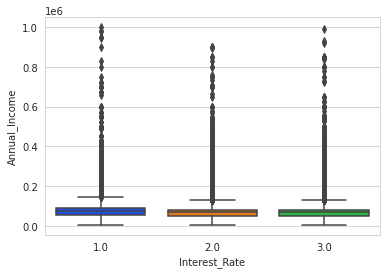

In [90]:
sns.boxplot('Interest_Rate','Annual_Income', data = df_train[df_train['Annual_Income']<1000000])

In [0]:
df_train.drop(df_train[df_train['Annual_Income']>1000000].index, inplace= True)

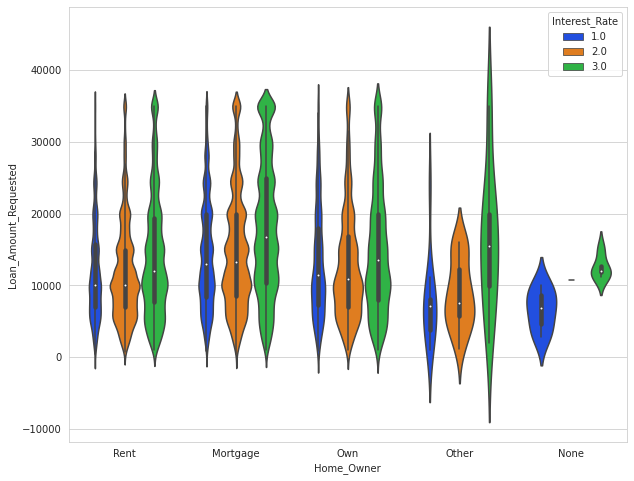

In [92]:
plt.figure(figsize = (10,8))
sns.violinplot('Home_Owner', 'Loan_Amount_Requested', data = df_train, hue = 'Interest_Rate', scale= 'count')

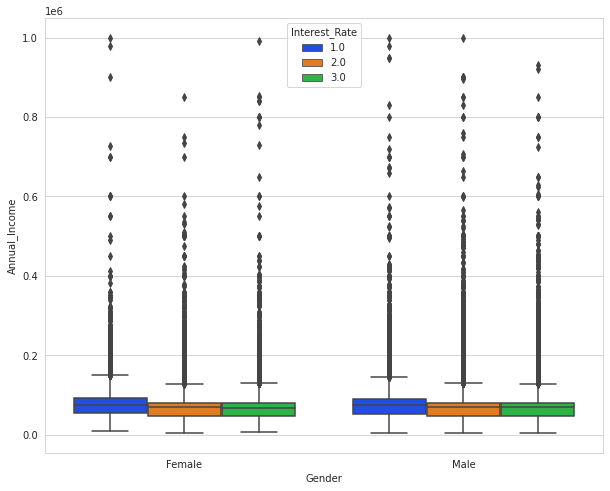

In [93]:
plt.figure(figsize = (10,8))
sns.boxplot('Gender', 'Annual_Income', data = df_train, hue = 'Interest_Rate')

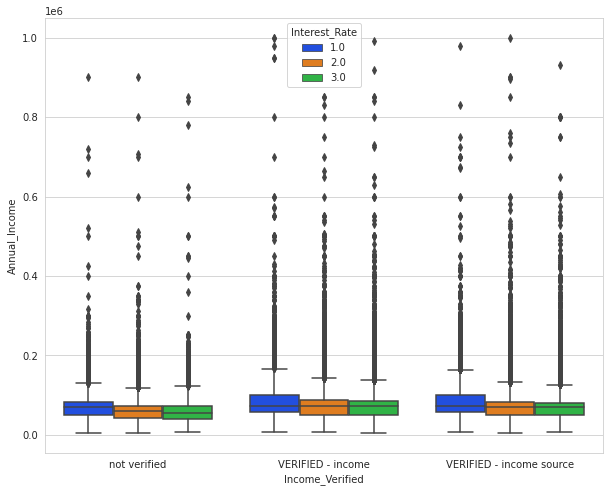

In [96]:
plt.figure(figsize = (10,8))
sns.boxplot('Income_Verified', 'Annual_Income', data = df_train, hue = 'Interest_Rate')